# Importing and Initializing

In [ ]:
#@title Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import shuffle
from scipy.io import loadmat
from collections import Counter, defaultdict

import tensorflow
from scipy.stats import uniform
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, LSTM, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

print(tensorflow.version.VERSION)
print("Imports done!")

2.9.0
Imports done!


In [ ]:
#@title Create model function
def create_model(batch_size=32, epochs=30, optimizer='adam', filters_1=64, filters_2=32, kernel_size_1=3, kernel_size_2=3, dropout_1=0.2, dropout_2=0.6, hidden_units=128, num_classes=2):
    model = Sequential()
    model.add(Conv2D(filters=filters_1, kernel_size=(kernel_size_1, kernel_size_1), activation='relu', input_shape=(12, X.shape[1], 1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout_1))
    model.add(Conv2D(filters=filters_2, kernel_size=(kernel_size_2, kernel_size_2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout_2))
    model.add(Flatten())
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
#@title Loading data function
def load_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [ ]:
MAXLEN = 2000
XX = []
yy = []
folder_path = "/Users/omarxbadawi/Downloads/folder2"

for root, dirs, files in os.walk(folder_path):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        for file_name in sorted(os.listdir(dir_path)):
            if file_name.endswith(".mat"):
                file_path = os.path.join(dir_path, file_name)
                data, header_data = load_data(file_path)
                data = pad_sequences(data, maxlen=MAXLEN, truncating='post',padding="post")
                XX.append(data)
                yy.append(header_data[15][5:-1])

In [ ]:
NUM_CLASSES = 3

# Create a dictionary that maps each label to a list of its samples
label_to_samples = defaultdict(list)
for sample, label in zip(XX, yy):
    label_to_samples[label].append(sample)

# Sort the labels by their counts and take the top k labels
label_counts = {label: len(samples) for label, samples in label_to_samples.items()}
top_k_labels = sorted(label_counts.keys(), key=lambda label: label_counts[label], reverse=True)[:NUM_CLASSES]

# Extract the samples for the top k labels from the dictionary
filtered_X = [sample for label in top_k_labels for sample in label_to_samples[label]]
filtered_y = [label for label in top_k_labels for _ in range(label_counts[label])]

In [ ]:
label_counts = Counter(filtered_y)

sorted_labels = [label for label, count in label_counts.most_common()]
sorted_counts = [count for label, count in label_counts.most_common()]

# Print the sorted labels and counts
print(sorted_counts)
print(sorted_labels)

# Output: [2, 1, 0, 3]

[9182, 1605, 1093]
['426783006', '59118001', '164889003']


In [ ]:
# Assuming filtered_X and filtered_y are your filtered data and label lists
unique_labels = list(set(filtered_y))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
integer_labels = [label_to_index[label] for label in filtered_y]

In [ ]:
# Combine X and y into a list of pairs
data = list(zip(filtered_X, integer_labels))

# Shuffle the list of pairs
shuffle(data)

# Split the shuffled pairs back into X and y
shuffled_X, shuffled_y = zip(*data)

# Data Preparation

In [ ]:
X = np.array(shuffled_X)
X = X.reshape(len(shuffled_X),MAXLEN,12)
y = np.array(shuffled_y)

In [ ]:
#@title Standardize the data
scaler = StandardScaler()
X_scaled = np.zeros(X.shape)
for i in range(X.shape[0]):
    scaler = StandardScaler()
    X_scaled[i,:] = scaler.fit_transform(X[i,:])

In [ ]:
#@title Reshape the data for input to the CNN
X_cnn = X_scaled.reshape(-1, 12, X.shape[1], 1)

In [ ]:
#@title Convert the labels to categorical format
y_categorical = to_categorical(y, num_classes=NUM_CLASSES)

In [ ]:
#@title Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_categorical, test_size=0.2, random_state=42)

# Hyperparameter optimization

In [ ]:
#@title Model wrapper method
def model_acc (permutations_dicts):
  accuracies = {}
  for i in range(len(permutations_dicts)):
    print(permutations_dicts[i])
    model = create_model(num_classes=NUM_CLASSES, **permutations_dicts[i])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stopping])
    _, acc = model.evaluate(X_test, y_test, batch_size=64)
    accuracies[str(permutations_dicts[i])] = acc
  return accuracies

In [ ]:
#@title Optimize filter size and kernel size using a grid search object 
param_grid = {'filters_1': [32, 64, 128],
              'kernel_size_1': [3, 5]}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(permutations_dicts)
D1 = model_acc(permutations_dicts)
print(D1)

In [ ]:
# Set figure size and font size
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})

# Create bar plot
plt.bar(D1.keys(), D1.values())

# Set x-axis label rotation for readability
plt.xticks(rotation=90, ha='right')

# Set plot title and axis labels
plt.title("Model Performance")
plt.xlabel("Model Architecture")
plt.ylabel("Accuracy")

plt.show()

In [ ]:
#@title Optimize filter size and kernel size using a grid search object 
param_grid = {'filters_2': [32, 64, 128],
              'kernel_size_2': [2, 3, 4]}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(permutations_dicts)
D2 = model_acc(permutations_dicts)
print(D2)

In [ ]:
# Set figure size and font size
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})

# Create bar plot
plt.bar(D2.keys(), D2.values())

# Set x-axis label rotation for readability
plt.xticks(rotation=90, ha='right')

# Set plot title and axis labels
plt.title("Model Performance")
plt.xlabel("Model Architecture")
plt.ylabel("Accuracy")

plt.show()

In [ ]:
#@title Optimize dropout rate using a grid search object 
param_grid = {'dropout_1': [0.1, 0.2, 0.3],
              'dropout_2': [0.1, 0.2, 0.3]}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(permutations_dicts)
D3 = model_acc(permutations_dicts)
print(D3)

In [ ]:
# Set figure size and font size
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 14})

# Create bar plot
plt.bar(D2.keys(), D3.values())

# Set x-axis label rotation for readability
plt.xticks(rotation=90, ha='right')

# Set plot title and axis labels
plt.title("Model Performance")
plt.xlabel("Model Architecture")
plt.ylabel("Accuracy")

plt.show()

In [ ]:
#@title Optimize filter size and kernel size using a grid search object 
param_grid = {'filters_1': [32, 64, 128],
              'kernel_size_1': [3, 5, 7]}

# Sample the parameter distribution and convert the values to integers
model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, verbose=1, epochs = 10, batch_size = 10)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

/var/folders/04/8m4s7knd7jzdfq07vp658k840000gn/T/ipykernel_99220/753914237.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, verbose=1, epochs = 10, batch_size = 10)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/10


2023-03-17 02:46:40.869553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


677/677 [==============================] - 15s 22ms/step - loss: 0.7895 - accuracy: 0.7292
Epoch 2/10
677/677 [==============================] - 14s 21ms/step - loss: 0.6426 - accuracy: 0.7782
Epoch 3/10
677/677 [==============================] - 15s 22ms/step - loss: 0.5383 - accuracy: 0.8226
Epoch 4/10
677/677 [==============================] - 14s 21ms/step - loss: 0.4899 - accuracy: 0.8409
Epoch 5/10
677/677 [==============================] - 14s 21ms/step - loss: 0.4470 - accuracy: 0.8530
Epoch 6/10
677/677 [==============================] - 15s 22ms/step - loss: 0.4095 - accuracy: 0.8606
Epoch 7/10
677/677 [==============================] - 15s 22ms/step - loss: 0.3790 - accuracy: 0.8736
Epoch 8/10
677/677 [==============================] - 18s 26ms/step - loss: 0.3362 - accuracy: 0.8848
Epoch 9/10
677/677 [==============================] - 16s 24ms/step - loss: 0.3299 - accuracy: 0.8875
Epoch 10/10
 11/339 [..............................] - ETA: 3s - loss: 0.5237 - accuracy: 0.8

2023-03-17 02:49:13.759689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 4s 10ms/step - loss: 0.4921 - accuracy: 0.8489
Epoch 1/10
  1/677 [..............................] - ETA: 3:56 - loss: 1.4454 - accuracy: 0.3000

2023-03-17 02:49:18.021789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


677/677 [==============================] - 15s 22ms/step - loss: 0.8020 - accuracy: 0.7302
Epoch 2/10
677/677 [==============================] - 15s 22ms/step - loss: 0.6331 - accuracy: 0.7896
Epoch 3/10
677/677 [==============================] - 16s 23ms/step - loss: 0.5564 - accuracy: 0.8171
Epoch 4/10
677/677 [==============================] - 16s 23ms/step - loss: 0.5005 - accuracy: 0.8326
Epoch 5/10
677/677 [==============================] - 15s 23ms/step - loss: 0.4604 - accuracy: 0.8437
Epoch 6/10
677/677 [==============================] - 15s 22ms/step - loss: 0.4416 - accuracy: 0.8570
Epoch 7/10
677/677 [==============================] - 14s 21ms/step - loss: 0.4219 - accuracy: 0.8593
Epoch 8/10
677/677 [==============================] - 14s 21ms/step - loss: 0.3859 - accuracy: 0.8703
Epoch 9/10
677/677 [==============================] - 14s 21ms/step - loss: 0.3713 - accuracy: 0.8733
Epoch 10/10
 10/339 [..............................] - ETA: 3s - loss: 0.5418 - accuracy: 0.8

2023-03-17 02:51:47.088358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 3s 10ms/step - loss: 0.4724 - accuracy: 0.8397
Epoch 1/10


2023-03-17 02:51:51.024270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


677/677 [==============================] - 15s 21ms/step - loss: 0.7958 - accuracy: 0.7278
Epoch 2/10
677/677 [==============================] - 14s 21ms/step - loss: 0.5946 - accuracy: 0.8023
Epoch 3/10
677/677 [==============================] - 15s 21ms/step - loss: 0.5208 - accuracy: 0.8261
Epoch 4/10
677/677 [==============================] - 14s 21ms/step - loss: 0.4629 - accuracy: 0.8458
Epoch 5/10
677/677 [==============================] - 14s 21ms/step - loss: 0.4202 - accuracy: 0.8542
Epoch 6/10
677/677 [==============================] - 14s 21ms/step - loss: 0.3843 - accuracy: 0.8686
Epoch 7/10
677/677 [==============================] - 15s 22ms/step - loss: 0.3587 - accuracy: 0.8819
Epoch 8/10
677/677 [==============================] - 15s 22ms/step - loss: 0.3372 - accuracy: 0.8853
Epoch 9/10
677/677 [==============================] - 15s 22ms/step - loss: 0.3212 - accuracy: 0.8890
Epoch 10/10
 10/339 [..............................] - ETA: 3s - loss: 0.3577 - accuracy: 0.8

2023-03-17 02:54:17.543309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 4s 10ms/step - loss: 0.4724 - accuracy: 0.8563
Epoch 1/10


2023-03-17 02:54:21.746982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


677/677 [==============================] - 14s 20ms/step - loss: 0.7906 - accuracy: 0.7284
Epoch 2/10
677/677 [==============================] - 14s 20ms/step - loss: 0.6443 - accuracy: 0.7741
Epoch 3/10
677/677 [==============================] - 13s 20ms/step - loss: 0.5193 - accuracy: 0.8315
Epoch 4/10
677/677 [==============================] - 13s 20ms/step - loss: 0.4632 - accuracy: 0.8458
Epoch 5/10
677/677 [==============================] - 13s 19ms/step - loss: 0.4162 - accuracy: 0.8612
Epoch 6/10
677/677 [==============================] - 13s 20ms/step - loss: 0.3807 - accuracy: 0.8740
Epoch 7/10
677/677 [==============================] - 13s 20ms/step - loss: 0.3724 - accuracy: 0.8770
Epoch 8/10
677/677 [==============================] - 13s 20ms/step - loss: 0.3131 - accuracy: 0.8961
Epoch 9/10
677/677 [==============================] - 13s 20ms/step - loss: 0.2908 - accuracy: 0.9032
Epoch 10/10
  9/339 [..............................] - ETA: 4s - loss: 0.4532 - accuracy: 0.8

2023-03-17 02:56:36.006025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 4s 11ms/step - loss: 0.4685 - accuracy: 0.8510
Epoch 1/10


2023-03-17 02:56:40.625689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


677/677 [==============================] - 14s 20ms/step - loss: 0.7949 - accuracy: 0.7253
Epoch 2/10
677/677 [==============================] - 13s 19ms/step - loss: 0.6688 - accuracy: 0.7737
Epoch 3/10
677/677 [==============================] - 13s 20ms/step - loss: 0.5738 - accuracy: 0.8010
Epoch 4/10
332/677 [=============>................] - ETA: 26:45 - loss: 0.5179 - accuracy: 0.8202

In [ ]:
#@title Print the best parameters
print("Best parameters:", grid_search.best_params_)

In [ ]:
#@title Optimize hyperparameters using a grid search object 
param_grid = {'batch_size': [32, 64, 128],
              'epochs': [10, 20, 30],
              'optimizer': ['adam', 'rmsprop'],
              'filters_1': [32, 64, 128],
              'filters_2': [32, 64, 128],
              'kernel_size_1': [3, 5, 7],
              'kernel_size_2': [3, 5, 7],
              'dropout_1': [0.2, 0.4, 0.6],
              'dropout_2': [0.2, 0.4, 0.6],
              'hidden_units': [128, 256, 512]}

# Sample the parameter distribution and convert the values to integers
model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, verbose=1, epochs = 10, batch_size = 10)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=6, cv=5, verbose=1, random_state=42)

# Fit the random search object to the training data
random_search.fit(X_train, y_train)

In [ ]:
#@title Print the best parameters
print("Best parameters:", random_search.best_params_)

# Model training

In [ ]:
#@title Compile the model
model = create_model(num_classes=NUM_CLASSES)

# categorical_crossentropy vs mse
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
#@title Set up early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#@title Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.1, callbacks=[early_stopping])
model.save('my_model.h5')

Epoch 1/30


2023-03-23 12:42:04.657040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.7670

2023-03-23 12:42:11.603442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 103ms/step - loss: 0.1527 - accuracy: 0.7670 - val_loss: 0.1417 - val_accuracy: 0.7792
Epoch 2/30
67/67 [==============================] - 7s 99ms/step - loss: 0.1079 - accuracy: 0.7761 - val_loss: 0.1219 - val_accuracy: 0.8191
Epoch 3/30
67/67 [==============================] - 7s 100ms/step - loss: 0.0873 - accuracy: 0.8295 - val_loss: 0.0853 - val_accuracy: 0.8507
Epoch 4/30
67/67 [==============================] - 7s 100ms/step - loss: 0.0746 - accuracy: 0.8533 - val_loss: 0.1033 - val_accuracy: 0.8233
Epoch 5/30
67/67 [==============================] - 7s 101ms/step - loss: 0.0657 - accuracy: 0.8705 - val_loss: 0.0639 - val_accuracy: 0.8864
Epoch 6/30
67/67 [==============================] - 7s 100ms/step - loss: 0.0594 - accuracy: 0.8826 - val_loss: 0.1600 - val_accuracy: 0.6656
Epoch 7/30
67/67 [==============================] - 7s 101ms/step - loss: 0.0562 - accuracy: 0.8927 - val_loss: 0.0954 - val_accuracy: 0.7886
Epoch 8/30
67/67 [

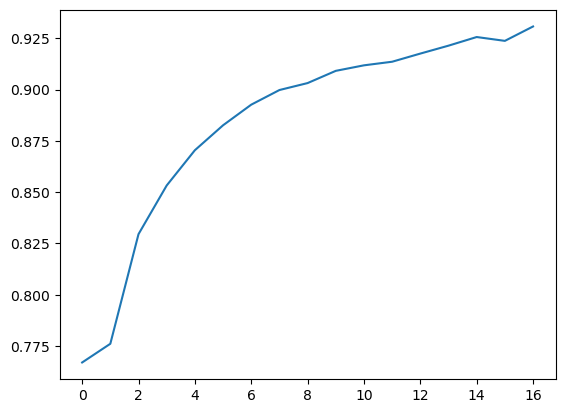

In [ ]:
# @title Plot accuracy during training
plt.plot(history.history['accuracy'])
plt.show()

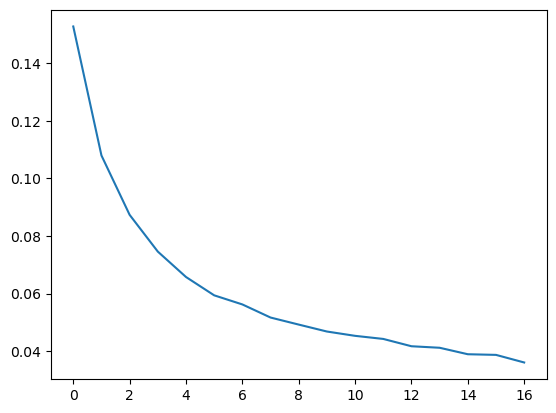

In [ ]:
#@title Plot loss during training
plt.plot(history.history['loss'])
plt.show()

38/38 [==============================] - 1s 19ms/step - loss: 0.0482 - accuracy: 0.9061

Test score/loss: 0.04824886471033096
Test accuracy: 0.9061447978019714
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


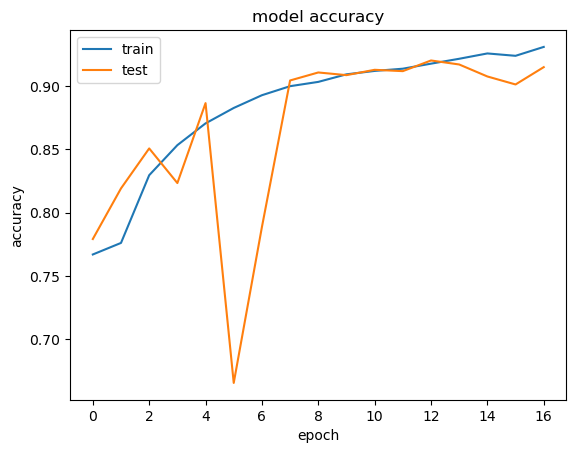

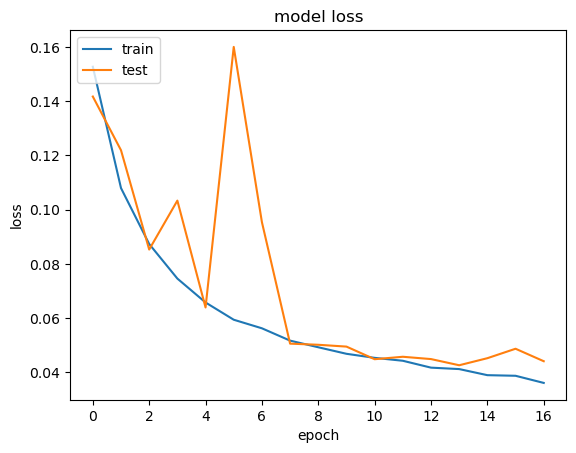

In [ ]:
#@title Testing
# score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())

# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
#@title Evaluate the model with test data previously generated
score, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

38/38 [==============================] - 1s 18ms/step - loss: 0.0482 - accuracy: 0.9061
Test score: 0.04824886471033096
Test accuracy: 0.9061447978019714


In [ ]:
#@title Make predictions on the test data
y_pred = model.predict(X_test)

14/75 [====>.........................] - ETA: 0s

2023-03-23 12:44:15.734083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 1s 9ms/step


In [ ]:
#@title The predicted class is the one with the highest probability
predicted_class = np.argmax(y_pred, axis=1)

In [ ]:
#@title Convert the predicted class labels to categorical format
y_pred_categorical = to_categorical(predicted_class, num_classes=NUM_CLASSES)

In [ ]:
#@title Calculate the model accuracy
accuracy = accuracy_score(y_test, y_pred_categorical)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 90.61%


In [ ]:
#@title Evaluate the model using 5-fold cross-validation (training data).
model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, epochs=10, batch_size=64, verbose=1)
scores = cross_val_score(model, X_train, y_train, cv=5)

/var/folders/04/8m4s7knd7jzdfq07vp658k840000gn/T/ipykernel_1986/3875783958.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, epochs=10, batch_size=64, verbose=1)


Epoch 1/10


2023-03-23 12:44:20.246454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 6s 51ms/step - loss: 0.6357 - accuracy: 0.7686
Epoch 2/10
119/119 [==============================] - 6s 50ms/step - loss: 0.4688 - accuracy: 0.8168
Epoch 3/10
119/119 [==============================] - 6s 50ms/step - loss: 0.3388 - accuracy: 0.8860
Epoch 4/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2961 - accuracy: 0.9011
Epoch 5/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2635 - accuracy: 0.9066
Epoch 6/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2489 - accuracy: 0.9136
Epoch 7/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2163 - accuracy: 0.9217
Epoch 8/10
119/119 [==============================] - 6s 52ms/step - loss: 0.2132 - accuracy: 0.9246
Epoch 9/10
119/119 [==============================] - 6s 53ms/step - loss: 0.2034 - accuracy: 0.9271
Epoch 10/10
 4/30 [===>..........................] - ETA: 0s - loss: 0.2760 - accuracy: 0.9336

2023-03-23 12:45:21.711787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 19ms/step - loss: 0.3008 - accuracy: 0.9085
Epoch 1/10


2023-03-23 12:45:23.005320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 6s 48ms/step - loss: 0.6704 - accuracy: 0.7681
Epoch 2/10
119/119 [==============================] - 6s 52ms/step - loss: 0.4821 - accuracy: 0.8164
Epoch 3/10
119/119 [==============================] - 6s 49ms/step - loss: 0.3768 - accuracy: 0.8694
Epoch 4/10
119/119 [==============================] - 6s 49ms/step - loss: 0.3406 - accuracy: 0.8883
Epoch 5/10
119/119 [==============================] - 6s 52ms/step - loss: 0.2796 - accuracy: 0.9064
Epoch 6/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2629 - accuracy: 0.9106
Epoch 7/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2361 - accuracy: 0.9167
Epoch 8/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2175 - accuracy: 0.9266
Epoch 9/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2045 - accuracy: 0.9299
Epoch 10/10
 3/30 [==>...........................] - ETA: 0s - loss: 0.3422 - accuracy: 0.8906

2023-03-23 12:46:22.436878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 20ms/step - loss: 0.2706 - accuracy: 0.9116
Epoch 1/10


2023-03-23 12:46:23.761757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 6s 46ms/step - loss: 0.6610 - accuracy: 0.7669
Epoch 2/10
119/119 [==============================] - 6s 49ms/step - loss: 0.4950 - accuracy: 0.7928
Epoch 3/10
119/119 [==============================] - 7s 55ms/step - loss: 0.3778 - accuracy: 0.8698
Epoch 4/10
119/119 [==============================] - 6s 49ms/step - loss: 0.3165 - accuracy: 0.8928
Epoch 5/10
119/119 [==============================] - 6s 52ms/step - loss: 0.2819 - accuracy: 0.9066
Epoch 6/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2526 - accuracy: 0.9160
Epoch 7/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2355 - accuracy: 0.9206
Epoch 8/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2170 - accuracy: 0.9246
Epoch 9/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2043 - accuracy: 0.9283
Epoch 10/10
 3/30 [==>...........................] - ETA: 0s - loss: 0.1819 - accuracy: 0.9375

2023-03-23 12:47:23.089941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 19ms/step - loss: 0.2571 - accuracy: 0.9137
Epoch 1/10


2023-03-23 12:47:24.354863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 6s 46ms/step - loss: 0.7200 - accuracy: 0.7665
Epoch 2/10
119/119 [==============================] - 6s 50ms/step - loss: 0.5425 - accuracy: 0.7759
Epoch 3/10
119/119 [==============================] - 6s 49ms/step - loss: 0.4482 - accuracy: 0.8335
Epoch 4/10
119/119 [==============================] - 6s 50ms/step - loss: 0.3471 - accuracy: 0.8807
Epoch 5/10
119/119 [==============================] - 6s 49ms/step - loss: 0.3075 - accuracy: 0.8921
Epoch 6/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2921 - accuracy: 0.9011
Epoch 7/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2597 - accuracy: 0.9120
Epoch 8/10
119/119 [==============================] - 6s 49ms/step - loss: 0.2469 - accuracy: 0.9135
Epoch 9/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2321 - accuracy: 0.9219
Epoch 10/10
 3/30 [==>...........................] - ETA: 0s - loss: 0.2790 - accuracy: 0.8958

2023-03-23 12:48:23.208437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 19ms/step - loss: 0.2949 - accuracy: 0.8985
Epoch 1/10


2023-03-23 12:48:24.476537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 6s 47ms/step - loss: 0.6786 - accuracy: 0.7664
Epoch 2/10
119/119 [==============================] - 6s 49ms/step - loss: 0.5430 - accuracy: 0.7717
Epoch 3/10
119/119 [==============================] - 6s 50ms/step - loss: 0.4483 - accuracy: 0.8264
Epoch 4/10
119/119 [==============================] - 6s 52ms/step - loss: 0.3625 - accuracy: 0.8764
Epoch 5/10
119/119 [==============================] - 6s 50ms/step - loss: 0.3064 - accuracy: 0.8933
Epoch 6/10
119/119 [==============================] - 6s 53ms/step - loss: 0.2750 - accuracy: 0.9052
Epoch 7/10
119/119 [==============================] - 6s 54ms/step - loss: 0.2444 - accuracy: 0.9136
Epoch 8/10
119/119 [==============================] - 6s 50ms/step - loss: 0.2364 - accuracy: 0.9158
Epoch 9/10
119/119 [==============================] - 6s 52ms/step - loss: 0.1969 - accuracy: 0.9299
Epoch 10/10
 3/30 [==>...........................] - ETA: 0s - loss: 0.3530 - accuracy: 0.8646

2023-03-23 12:49:25.234125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 20ms/step - loss: 0.2777 - accuracy: 0.9095


In [ ]:
#@title Calculate mean model accuracy and its standard deviation
mean, std = np.array(scores).mean(), np.array(scores).std()

print("List of accuracies: " + str(scores))
print("Mean model accuracy: {:.2f}%".format(mean*100))
print("STD of model accuracy: {:.2f}%".format(std*100))

List of accuracies: [0.90846926 0.91162544 0.91372961 0.89847451 0.90947372]
Mean model accuracy: 90.84%
STD of model accuracy: 0.53%


In [ ]:
#@title Evaluate the model using 5-fold cross-validation (test data).
model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, epochs=10, batch_size=64, verbose=1)
scores = cross_val_score(model, X_test, y_test, cv=5)

Epoch 1/10


/var/folders/04/8m4s7knd7jzdfq07vp658k840000gn/T/ipykernel_1986/2928142719.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, num_classes=NUM_CLASSES, epochs=10, batch_size=64, verbose=1)
2023-03-23 12:50:39.943868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 56ms/step - loss: 0.8236 - accuracy: 0.7663
Epoch 2/10
30/30 [==============================] - 1s 47ms/step - loss: 0.5882 - accuracy: 0.7784
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5274 - accuracy: 0.7784
Epoch 4/10
30/30 [==============================] - 1s 50ms/step - loss: 0.4504 - accuracy: 0.7868
Epoch 5/10
30/30 [==============================] - 2s 51ms/step - loss: 0.3913 - accuracy: 0.8416
Epoch 6/10
30/30 [==============================] - 2s 52ms/step - loss: 0.3500 - accuracy: 0.8532
Epoch 7/10
30/30 [==============================] - 2s 51ms/step - loss: 0.3018 - accuracy: 0.8821
Epoch 8/10
30/30 [==============================] - 2s 51ms/step - loss: 0.2606 - accuracy: 0.9016
Epoch 9/10
30/30 [==============================] - 1s 50ms/step - loss: 0.2371 - accuracy: 0.9142
Epoch 10/10
3/8 [==========>...................] - ETA: 0s - loss: 0.4557 - accuracy: 0.8281

2023-03-23 12:50:55.493590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 27ms/step - loss: 0.4312 - accuracy: 0.8655
Epoch 1/10


2023-03-23 12:50:56.094916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 47ms/step - loss: 0.9088 - accuracy: 0.7443
Epoch 2/10
30/30 [==============================] - 1s 49ms/step - loss: 0.6520 - accuracy: 0.7743
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5900 - accuracy: 0.7743
Epoch 4/10
30/30 [==============================] - 2s 51ms/step - loss: 0.5349 - accuracy: 0.7743
Epoch 5/10
30/30 [==============================] - 2s 56ms/step - loss: 0.4884 - accuracy: 0.7801
Epoch 6/10
30/30 [==============================] - 2s 53ms/step - loss: 0.4411 - accuracy: 0.8022
Epoch 7/10
30/30 [==============================] - 2s 50ms/step - loss: 0.4226 - accuracy: 0.8296
Epoch 8/10
30/30 [==============================] - 1s 50ms/step - loss: 0.3615 - accuracy: 0.8601
Epoch 9/10
30/30 [==============================] - 1s 50ms/step - loss: 0.3068 - accuracy: 0.8858
Epoch 10/10
3/8 [==========>...................] - ETA: 0s - loss: 0.4442 - accuracy: 0.8750

2023-03-23 12:51:11.572303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 26ms/step - loss: 0.4316 - accuracy: 0.8716
Epoch 1/10


2023-03-23 12:51:12.168593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 46ms/step - loss: 0.8558 - accuracy: 0.7538
Epoch 2/10
30/30 [==============================] - 1s 45ms/step - loss: 0.6223 - accuracy: 0.7780
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5644 - accuracy: 0.7780
Epoch 4/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5152 - accuracy: 0.7806
Epoch 5/10
30/30 [==============================] - 1s 49ms/step - loss: 0.4670 - accuracy: 0.7975
Epoch 6/10
30/30 [==============================] - 1s 50ms/step - loss: 0.4032 - accuracy: 0.8306
Epoch 7/10
30/30 [==============================] - 1s 50ms/step - loss: 0.3517 - accuracy: 0.8601
Epoch 8/10
30/30 [==============================] - 1s 50ms/step - loss: 0.2962 - accuracy: 0.8927
Epoch 9/10
30/30 [==============================] - 1s 50ms/step - loss: 0.2490 - accuracy: 0.9143
Epoch 10/10
3/8 [==========>...................] - ETA: 0s - loss: 0.3950 - accuracy: 0.8906

2023-03-23 12:51:27.174708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 25ms/step - loss: 0.4065 - accuracy: 0.8800
Epoch 1/10


2023-03-23 12:51:27.762669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 49ms/step - loss: 0.8670 - accuracy: 0.7464
Epoch 2/10
30/30 [==============================] - 1s 44ms/step - loss: 0.6372 - accuracy: 0.7733
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5931 - accuracy: 0.7733
Epoch 4/10
30/30 [==============================] - 2s 50ms/step - loss: 0.5419 - accuracy: 0.7733
Epoch 5/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5109 - accuracy: 0.7806
Epoch 6/10
30/30 [==============================] - 1s 50ms/step - loss: 0.4624 - accuracy: 0.8022
Epoch 7/10
30/30 [==============================] - 2s 50ms/step - loss: 0.4085 - accuracy: 0.8401
Epoch 8/10
30/30 [==============================] - 2s 51ms/step - loss: 0.3514 - accuracy: 0.8811
Epoch 9/10
30/30 [==============================] - 1s 50ms/step - loss: 0.2821 - accuracy: 0.8932
Epoch 10/10
3/8 [==========>...................] - ETA: 0s - loss: 0.4040 - accuracy: 0.8490

2023-03-23 12:51:42.868542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 24ms/step - loss: 0.3975 - accuracy: 0.8589
Epoch 1/10


2023-03-23 12:51:43.476687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 56ms/step - loss: 0.8038 - accuracy: 0.7585
Epoch 2/10
30/30 [==============================] - 1s 37ms/step - loss: 0.5869 - accuracy: 0.7785
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5713 - accuracy: 0.7780
Epoch 4/10
30/30 [==============================] - 1s 50ms/step - loss: 0.5176 - accuracy: 0.7785
Epoch 5/10
30/30 [==============================] - 2s 52ms/step - loss: 0.4707 - accuracy: 0.7912
Epoch 6/10
30/30 [==============================] - 2s 50ms/step - loss: 0.4056 - accuracy: 0.8359
Epoch 7/10
30/30 [==============================] - 2s 51ms/step - loss: 0.3631 - accuracy: 0.8627
Epoch 8/10
30/30 [==============================] - 1s 50ms/step - loss: 0.2931 - accuracy: 0.8895
Epoch 9/10
30/30 [==============================] - 1s 50ms/step - loss: 0.3014 - accuracy: 0.8890
Epoch 10/10
3/8 [==========>...................] - ETA: 0s - loss: 0.5504 - accuracy: 0.8177

2023-03-23 12:51:59.349851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 27ms/step - loss: 0.4642 - accuracy: 0.8400


In [ ]:
#@title Calculate mean model accuracy and its standard deviation
mean, std = np.array(scores).mean(), np.array(scores).std()

print("List of accuracies: " + str(scores))
print("Mean model accuracy: {:.2f}%".format(mean*100))
print("STD of model accuracy: {:.2f}%".format(std*100))

List of accuracies: [0.86554629 0.87157899 0.88000005 0.8589474  0.84000003]
Mean model accuracy: 86.32%
STD of model accuracy: 1.35%


# Visualize ECG

In [ ]:
#@title Create plot function
def create_plot (signal):
  ecg_signal = signal

  # Lead names
  lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  # Get the number of leads
  num_leads = ecg_signal.shape[0]

  # Create a figure and axis for each lead
  fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

  # Flatten the axis array
  ax = ax.flatten()

  # Plot each lead
  for i in range(num_leads):
      ax[i].plot(ecg_signal[i, :])
      ax[i].set_xlabel('Time (s)')
      ax[i].set_ylabel('Amplitude (mV)')
      ax[i].set_title(lead_names[i])
      

  # Hide unused subplots
  for i in range(num_leads, len(ax)):
      ax[i].axis('off')

  # Show the plot
  plt.tight_layout()
  plt.show()

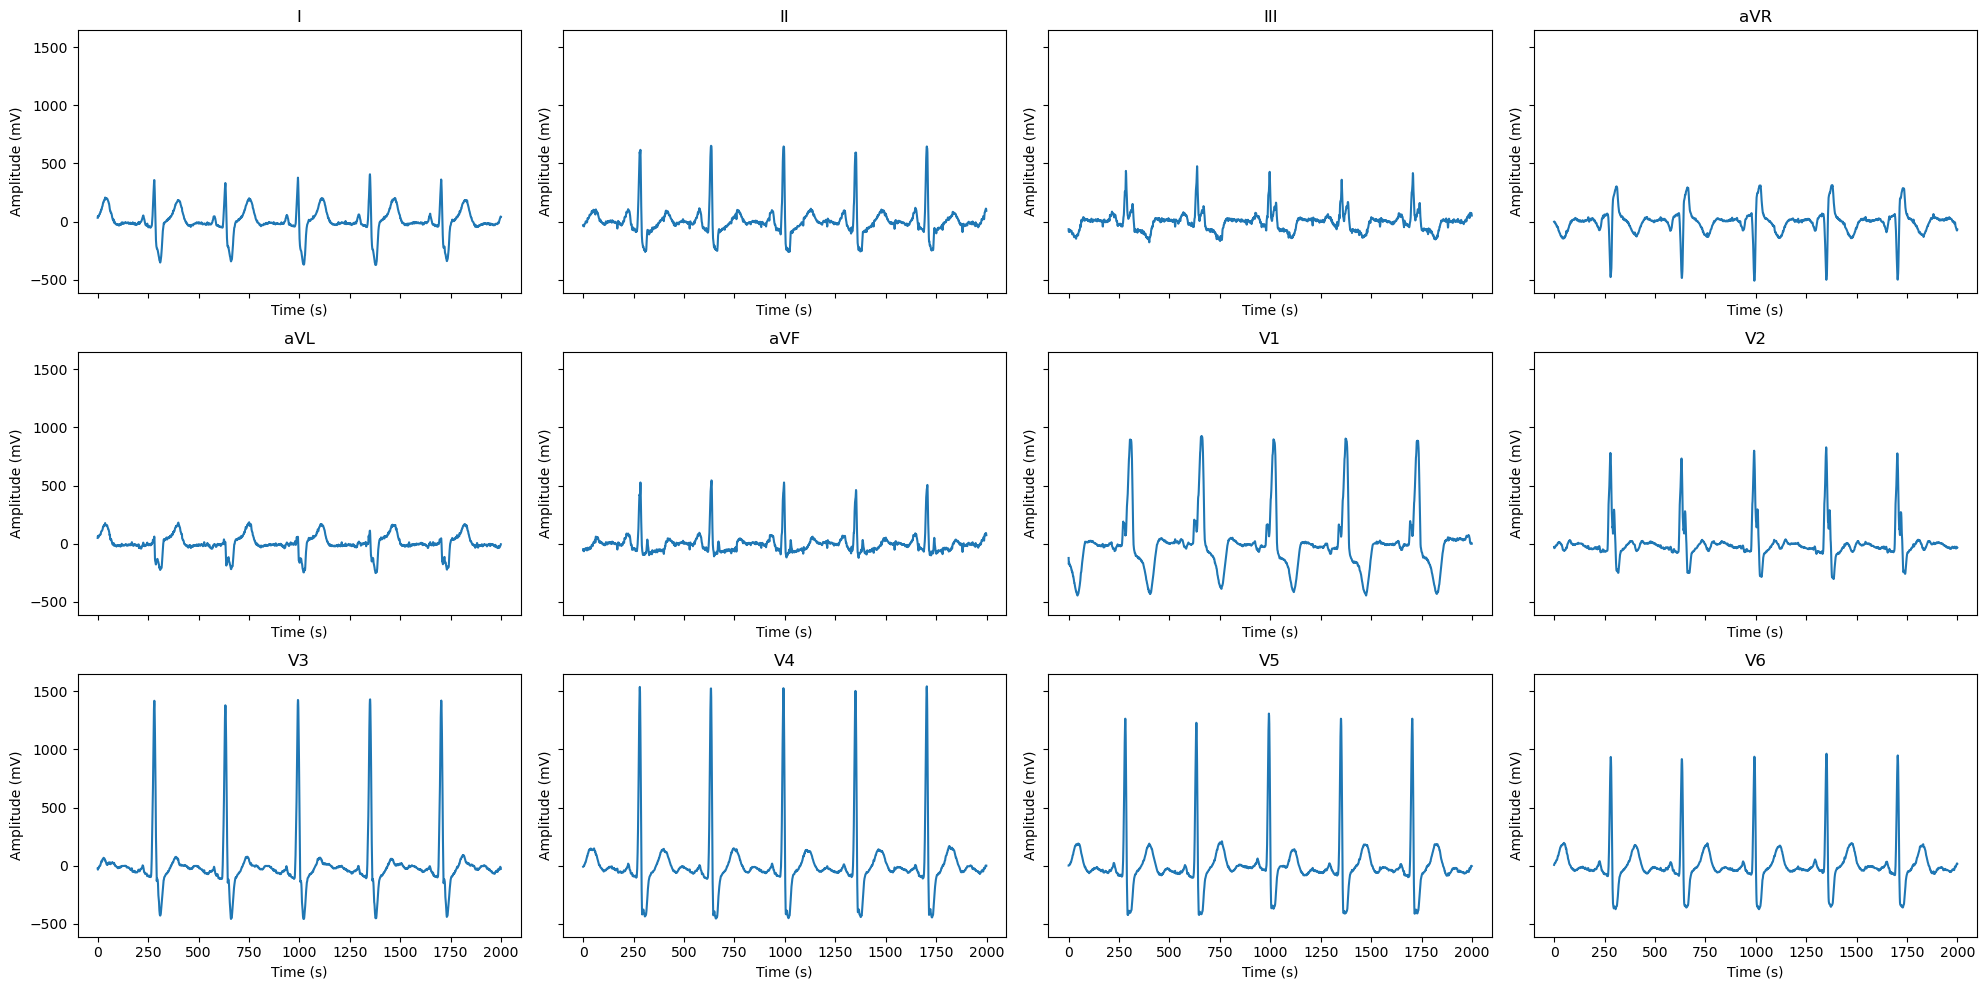

In [ ]:
create_plot(shuffled_X[393])

# LIME

In [ ]:
X_2d = np.reshape(X_cnn, (X_cnn.shape[0], -1))
X_2d.shape

(12683, 24000)

In [ ]:
# create a wrapper function that takes in 2D data, reshapes it, and passes it to the model for prediction
def predict_fn(data):
    data_reshaped = np.reshape(data, (-1, 12, 2000, 1))
    return model.predict(data_reshaped)

In [ ]:
import lime
from lime import lime_tabular
feature_names = ['lead_{}_time_{}'.format(i // 2000 + 1, i % 2000) for i in range(X_2d.shape[1])]
# explainer2 = lime_tabular.RecurrentTabularExplainer(X[:10], training_labels=y[:10], feature_names=["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"], discretize_continuous=True, discretizer='decile')
explainer = lime_tabular.LimeTabularExplainer(X_2d, feature_names=feature_names, class_names=range(36), verbose=True, mode='classification')


In [ ]:
# exp = explainer.explain_instance(X_cnn[1], model.predict, num_features=8, labels=(27,), num_samples=5)
exp = explainer.explain_instance(X_2d[29], predict_fn, num_features=30, num_samples=5000)
exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 2s 11ms/step
Intercept 0.6762755577335638
Prediction_local [0.67523567]
Right: 0.6632752


In [ ]:
# Print the top features contributing to the predicted class
print(exp.as_list())

[('lead_8_time_845 <= -0.35', -0.00048126206899262795), ('lead_1_time_1014 > 0.11', -0.00047978648177541595), ('-0.15 < lead_2_time_1100 <= 0.15', 0.0004739747473397462), ('0.10 < lead_7_time_197 <= 0.36', -0.0004714684520878011), ('lead_2_time_219 <= -0.42', 0.00043192959087753706), ('-0.38 < lead_2_time_1522 <= -0.14', -0.0004290199826505873), ('-0.13 < lead_4_time_1501 <= 0.14', -0.00042034337597681316), ('lead_5_time_1010 > 0.13', -0.00041519572113980774), ('-0.04 < lead_5_time_1775 <= 0.14', 0.0004128869096932047), ('-0.15 < lead_9_time_1435 <= 0.31', 0.0004098327693472874), ('0.10 < lead_7_time_1136 <= 0.31', 0.00040544960094011045), ('lead_7_time_1269 > 0.31', -0.00038612131705911536), ('lead_11_time_1203 > 0.11', -0.0003759838978285127), ('-0.16 < lead_9_time_1527 <= 0.30', -0.0003672031892896075), ('lead_4_time_861 <= -0.11', -0.00034705855148051904), ('lead_2_time_1170 > 0.15', -0.0003470257279894243), ('lead_6_time_1713 <= -0.27', 0.00033351596557808753), ('lead_10_time_1714

In [ ]:
def create_plot2(signal, top_features):
    ecg_signal = signal

    # Lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Get the number of leads
    num_leads = ecg_signal.shape[0]

    # Create a figure and axis for each lead
    fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

    # Flatten the axis array
    ax = ax.flatten()

    # Plot each lead
    for i in range(num_leads):
        ax[i].plot(ecg_signal[i, :])
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('Amplitude (mV)')
        ax[i].set_title(lead_names[i])

        # plot the top features as red dots
        for feature, weight in top_features:
            # get the lead number from the feature name
            feature_lead = int(feature.split('_')[1])

            # check if the feature corresponds to the current lead
            if feature_lead == i + 1:
                # get the feature index
                feature_idx = int(feature.split('_')[-1].split(' ')[0])
                ax[i].scatter(feature_idx, ecg_signal[i, feature_idx], color='r')

    plt.show()

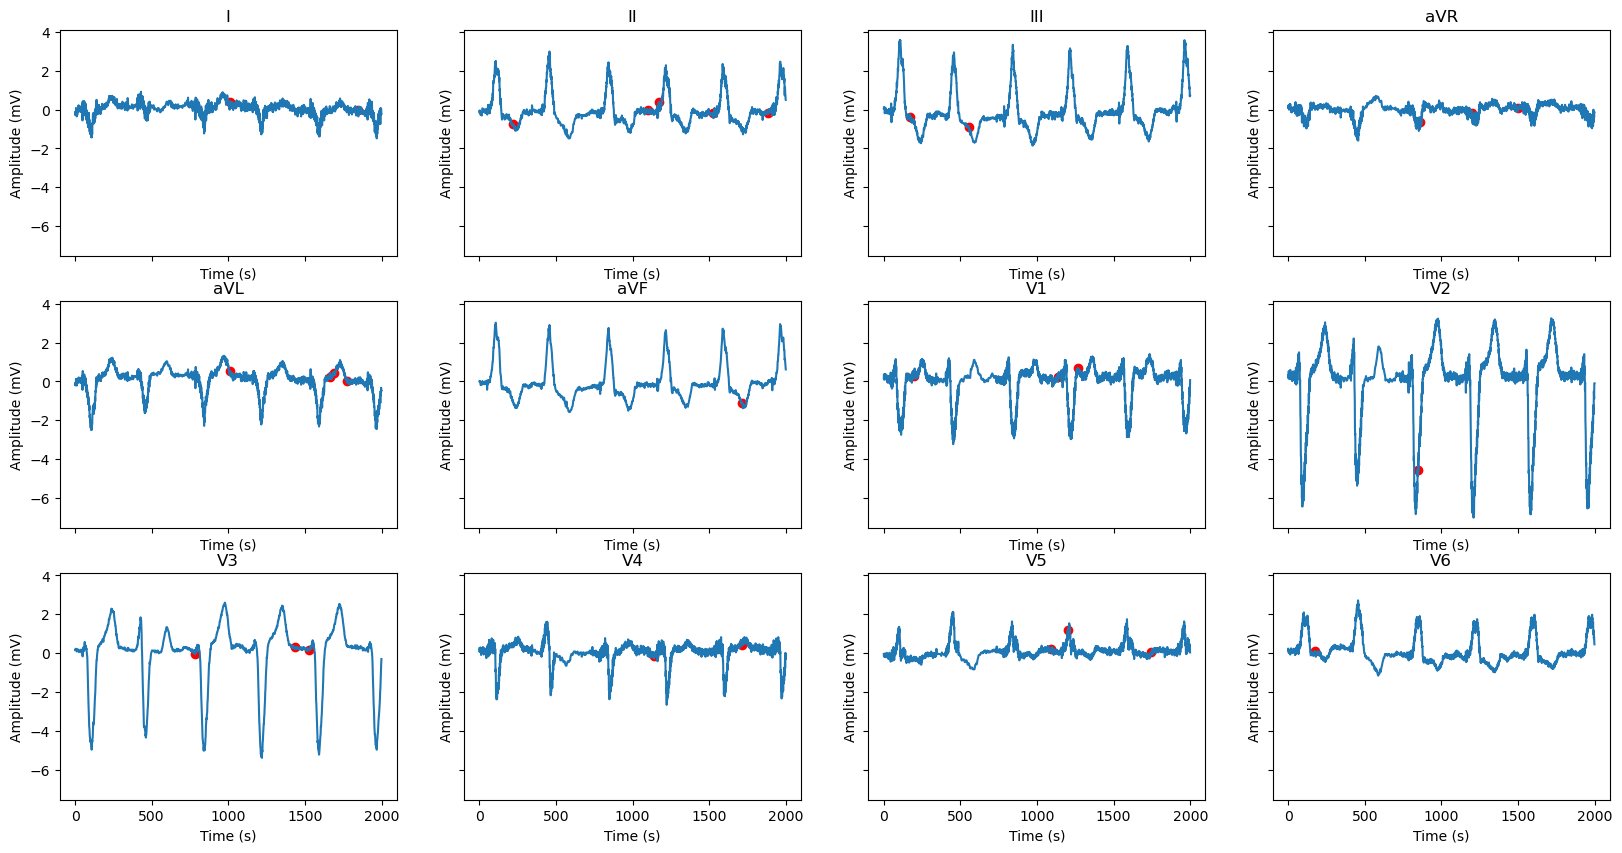

In [ ]:
# get the feature weights from the LIME explanation
weights = exp.as_list()

# sort the weights by absolute value
weights_sorted = sorted(weights, key=lambda x: abs(x[1]), reverse=True)

# get the top 12 features
top_features = weights_sorted

# create the plot
create_plot2(X_cnn[29].squeeze(), top_features)

In [ ]:
def predict_sample(sample, top = 3):
    # Reshape the input sample to match the expected input shape of the model
    sample = sample.reshape(1, 12, X.shape[1], 1)
    
    # Use the model to predict the probabilities of each class for the input sample
    prob = model.predict(sample, verbose=0)
    
    # Associate each predicted probability with its corresponding class label
    label_probs = list(zip(sorted_labels, prob[0]))
    
    # Sort the list of label-probability pairs in descending order of probability
    label_probs.sort(key=lambda x: x[1], reverse=True)

    # Map SNOMED CT codes to disease names
    code_to_name = dict(zip(dx['SNOMED CT Code'].astype(str), dx['Dx']))
    
    # Convert each label-probability pair to a disease name-probability pair
    label_probs_names = [(code_to_name.get(label, label), prob) for label, prob in label_probs]

    # Combine probabilities for diseases with multiple SNOMED CT codes (indicated by commas in the label) and use
    # the disease name as the key in a dictionary
    labels_dict = {}
    for label, prob in label_probs_names:
        if "," in label:
            codes = label.split(",")
            names = [code_to_name.get(code, code) for code in codes]
            name_str = " & ".join(names)
            labels_dict[name_str] = prob
        else:
            labels_dict[code_to_name.get(label, label)] = prob

    # Sort the diseases in descending order of probability and return the top 'top' diseases as a list of tuples
    sorted_labelss = sorted(labels_dict.items(), key=lambda x: x[1], reverse=True)

    results = []
    for label, prob in sorted_labelss[:top]:
        results.append((label, prob))

    return results

In [ ]:
def print_results(results):
  for i, (diagnosis, probability) in enumerate(results[:3], start=1):
    print(f"{i}. {diagnosis}: {probability*100:.2f}%")

In [ ]:
dx = pd.read_csv('/Users/omarxbadawi/Downloads/Dx_map.csv')

print_results(predict_sample(X_cnn[29]))

1. right bundle branch block: 66.33%
2. atrial fibrillation: 16.35%
3. sinus rhythm: 13.79%


In [ ]:
def find_indices(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

In [ ]:
ind = find_indices(shuffled_y, 0)

for i in range(5):
  print(ind[i], end=" -> ")
  print_results(predict_sample(X_cnn[ind[i]], 1))

23 -> 1. right bundle branch block: 63.55%
28 -> 1. right bundle branch block: 37.12%
63 -> 1. nonspecific st t abnormality: 72.77%
68 -> 1. right bundle branch block: 41.09%
72 -> 1. right bundle branch block: 52.97%


# Draft

In [ ]:
class_names

In [ ]:
sample = X_cnn[0].reshape(1, 12, X.shape[1], 1)
prob = model.predict(sample)

In [ ]:
label_probs = list(zip(classes, prob[0]))

In [ ]:
label_probs.sort(key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(3):
    label, prob = label_probs[i]
    print(f"{label}: {float(prob)*100:.2f}%")

In [ ]:
class_names = []
code_to_name = dict(zip(dx['SNOMED CT Code'].astype(str), dx['Dx']))
for c in classes:
    codes = c.split(",")
    names = [code_to_name[code] for code in codes]
    class_names.append(", ".join(names))

In [ ]:
y[200]

# Draft 2 (GradCAM)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

# Create a new model that outputs the activations of the final convolutional layer
layer_name = 'conv2d_13'
conv_layer = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
# Load the ECG signal data
ecg_signal = X_train

# Choose the class index
class_idx = 0

# Calculate the Grad-CAM heatmap for each lead
heatmaps = []
for i in range(12):
    input_data = np.expand_dims(ecg_signal[i, :, np.newaxis], axis=0)
    
input_data = np.transpose(input_data, (0, 1, 3, 4, 2))
input_data = np.reshape(input_data, (1, 12, 1000, 1))
activations = conv_layer(input_data)

print("activations shape:", activations.shape)
print("model.output[:, class_idx] shape:", model.output[:, class_idx].shape)

In [ ]:
# Create a function to calculate the gradient of the class output with respect to the activations of the final convolutional layer
def grad_cam(input_data, class_idx, layer_name):
    input_data = np.transpose(input_data, (0, 1, 3, 4, 2))
    input_data = np.reshape(input_data, (1, 12, 1000, 1))

    # Get the activations of the final convolutional layer
    activations = conv_layer(input_data)
    
    # Calculate the gradient of the class output with respect to the activations of the final convolutional layer
    with tensorflow.GradientTape() as tape:
        tape.watch(activations)
        output = model(input_data)
        loss = output[:, class_idx]
    gradient = tape.gradient(loss, activations)
    gradient = K.mean(gradient, axis=(1, 2))
    
    # Get the function that computes the activations and gradients
    grad_fn = K.function([model.input], [activations, gradient])
    
    # Compute the activations and gradients
    activations, gradient = grad_fn([input_data])
    
    # Calculate the heatmap
    heatmap = np.mean(activations[0] * gradient[0], axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Resize the heatmap to the size of the input data
    heatmap = np.resize(heatmap, (input_data.shape[1], input_data.shape[2]))
    
    return heatmap

# Load the ECG signal data
ecg_signal = X_train

# Choose the class index
class_idx = 0

# Calculate the Grad-CAM heatmap for each lead
heatmaps = []
for i in range(12):
    input_data = np.expand_dims(ecg_signal[i, :, np.newaxis], axis=0)
    heatmaps.append(grad_cam(input_data, class_idx, layer_name))

# Plot the heatmaps
fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

# Flatten the axis array
ax = ax.flatten()

# Plot each heatmap
for i in range(12):
    ax[i].imshow(heatmaps[i], cmap='jet')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Amplitude (mV)')
    ax[i].set_title(f'Lead {i + 1}')

# Hide unused subplots
for i in range(12, len(ax)):
    fig.delaxes(ax[i])

# Add the ECG signal data to the heatmap plots
for i in range(12):
    ax[i].plot(ecg_signal[i, :])

plt.tight_layout()
plt.show()

In [ ]:
for i, layer in enumerate(model.layers):
    print(layer.name)

In [ ]:
# Choose the layer that you want to visualize and get its output
layer_name = 'conv2d_21'
intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Choose an image to visualize
img = X_test[0]
img = np.expand_dims(img, axis=0)

# Get the output of the chosen layer for the selected image
intermediate_output = intermediate_layer_model.predict(img)

# Get the weights of the output of the chosen layer
weights = model.get_layer(layer_name).get_weights()[0]

# Compute the gradients of the chosen layer's output with respect to the output of the model
with tf.GradientTape() as tape:
    tape.watch(intermediate_output)
    output = model(img)
    output = tf.reduce_sum(output)

grads = tape.gradient(output, intermediate_output)

# Compute the dot product of the gradients and the weights
weights_grads = np.sum(weights * grads[0], axis=(1, 2))

# Compute the heatmap
heatmap = np.sum(weights_grads[..., np.newaxis] * intermediate_output[0], axis=-1)


In [ ]:
def grad_cam(model, X, layer_name):
    """
    Computes the Grad-CAM heatmap for the input ECG signal.
    """
    X = np.expand_dims(X, axis=0)
    X = np.expand_dims(X, axis=-1)
    y_pred = model.predict(X)
    class_idx = np.argmax(y_pred[0])
    
    # Get the output of the target layer
    output = model.output[:, class_idx]
    layer = model.get_layer(layer_name)
    
    # Compute the gradients of the output with respect to the layer's activations
    target_class_idx = 0
    model = ... # Your trained Keras model
    input_sample = np.zeros((1, 12, 1000, 1))
    input_tensor = tf.convert_to_tensor(model.call)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        target_class_idx = ... # Index of the target class
        loss = output[:, target_class_idx]
    grads = tape.gradient(loss, input_tensor)

    pool_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Get the activations of the target layer
    iterate = K.function([model.input], [layer.output, pool_grads])
    activations, grads = iterate([X])
    activations = activations[0]
    
    # Apply the gradients to the activations
    for i in range(grads.shape[0]):
        activations[:, :, i] *= grads[i]
    
    # Average the activations along the channel axis to obtain the heatmap
    heatmap = np.mean(activations, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    
    # Resize the heatmap to the original size of the input ECG signal
    heatmap = cv2.resize(heatmap, (X.shape[2], X.shape[1]))
    
    return heatmap

# Get the Grad-CAM heatmap for a sample ECG signal
sample_ecg = X_test[0, :, :]
heatmap = grad_cam(model, sample_ecg, 'conv2d_19')